# Figure 12

In [1]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

/storage1/home1/chiaweih/anaconda2/envs/python3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: scheduler='inproc://128.196.236.68/21815/1' processes=1 cores=8>

In [2]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 133.328125 MB


# Model

In [3]:
#### possible input info from external text file
# constant setting
syear = 1993           
fyear = 2007

tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos']
Area_name = ['areacello_cu','areacello_cv','areacello']

Model_name = ['JRA','CORE']
Model_legend_name = ['JRA55-do','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [4]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [5]:
from xr_ufunc import da_linregress

#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA tauuo
read JRA tauvo
read JRA zos
read CORE tauuo
read CORE tauvo
read CORE zos


In [6]:
used_memory()

used 646.054688 MB


# Observation

In [7]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1950,2011],[1993,2018,9]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['tx','ty'],['adt']]

Obs_name = ['WESwind','CMEMS']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/WASWind/'
obsfile = [['waswind_v1_0_1.monthly.nc'],['waswind_v1_0_1.monthly.nc']]
obspath[obs]=[obsdir,obsfile]

obs = Obs_name[1]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/CMEMS/'
obsfile = [['dt_global_allsat_phy_l4_monthly_adt.nc']]
obspath[obs]=[obsdir,obsfile]


for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [8]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}
obs_linear_mlist = {}

In [9]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear)&\
                                 (ds_obs['time.year'] <= fyear)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
    obs_mean_mlist[obs] = obs_mean_list
    obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read WESwind tx
read WESwind ty
read CMEMS adt


In [10]:
used_memory()

used 1194.957031 MB


# Regridding

In [11]:
#### models
da_model_standard = xr.open_zarr(path_standard).isel(time=0).load()     

da_model_standard = da_model_standard\
                  .where((da_model_standard.lat >= np.min(np.array(tp_lat_region)))&\
                         (da_model_standard.lat <= np.max(np.array(tp_lat_region)))\
                         ,drop=True)

In [12]:
used_memory()

used 1227.714844 MB


In [13]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

da_pacific = levitus98(da_model_standard,
                       basin=['pac'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='x',
                       lat_name='y', 
                       new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [14]:
import xesmf as xe

# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(season_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRA_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRA_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
model variable same as standard model variable
Overwrite existing file: CORE_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_zos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [15]:
# create regridder
for nobs,obs in enumerate(Obs_name):
    regridder_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        regridder = xe.Regridder(obs_season_mlist[obs][var], 
                                 da_model_standard, 
                                 'bilinear',
                                 filename='%s_%s2%s_%s.nc'%(obs,var,Model_standard,Variable_standard),
                                 periodic=True,
                                 reuse_weights=False)
        regridder_list['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[obs] = regridder_list

Overwrite existing file: WESwind_tx2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: WESwind_ty2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CMEMS_adt2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [16]:
regrid_season_mlist = {}

for nmodel,model in enumerate(Model_name):
    regrid_season_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
            regrid_season_list[var] = season_mlist[model][var]
        else:
            regrid_season = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,
                                                    var,
                                                    Model_standard,
                                                    Variable_standard)](season_mlist[model][var])
            regrid_season_list[var] = regrid_season
            regrid_season_list[var]['x'] = da_model_standard.x.values
            regrid_season_list[var]['y'] = da_model_standard.y.values
    regrid_season_mlist[model] = regrid_season_list
                    

model variable same as standard model variable


In [17]:
obs_regrid_season_mlist = {}

for nobs,obs in enumerate(Obs_name):
    obs_regrid_season_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_regrid_season = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,
                                              var,
                                              Model_standard,
                                              Variable_standard)](obs_season_mlist[obs][var])
        obs_regrid_season_list[var] = obs_regrid_season
        obs_regrid_season_list[var]['x'] = da_model_standard.x.values
        obs_regrid_season_list[var]['y'] = da_model_standard.y.values
    obs_regrid_season_mlist[obs] = obs_regrid_season_list
                    

# Derive Ekman upwelling/downwelling and wind stress curl

In [18]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import curl_tau_3d, ekman_pumping2_3d_decompose


obs_regrid_season_mlist['WESwind']['Ek_tx'],\
obs_regrid_season_mlist['WESwind']['Ek_ty'],\
obs_regrid_season_mlist['WESwind']['Ek_curl'],\
obs_regrid_season_mlist['WESwind']['Ek_zonal'],\
                            = ekman_pumping2_3d_decompose(
                                                      obs_regrid_season_mlist['WESwind']['tx'],
                                                      obs_regrid_season_mlist['WESwind']['ty'],
                                                      eq_mask=True)
obs_regrid_season_mlist['WESwind']['curl_tx'],obs_regrid_season_mlist['WESwind']['curl_ty'] = curl_tau_3d(
                                               obs_regrid_season_mlist['WESwind']['tx'],
                                               obs_regrid_season_mlist['WESwind']['ty'])

for nmodel,model in enumerate(Model_name):
    regrid_season_mlist[model]['Ek_tauuo'],\
    regrid_season_mlist[model]['Ek_tauvo'],\
    regrid_season_mlist[model]['Ek_curl'],\
    regrid_season_mlist[model]['Ek_zonal']= ekman_pumping2_3d_decompose(
                                                      regrid_season_mlist[model]['tauuo'],
                                                      regrid_season_mlist[model]['tauvo'],
                                                      eq_mask=True)
    regrid_season_mlist[model]['curl_tauuo'],regrid_season_mlist[model]['curl_tauvo'] = curl_tau_3d(
                                               regrid_season_mlist[model]['tauuo'],
                                               regrid_season_mlist[model]['tauvo'])

# Plotting 

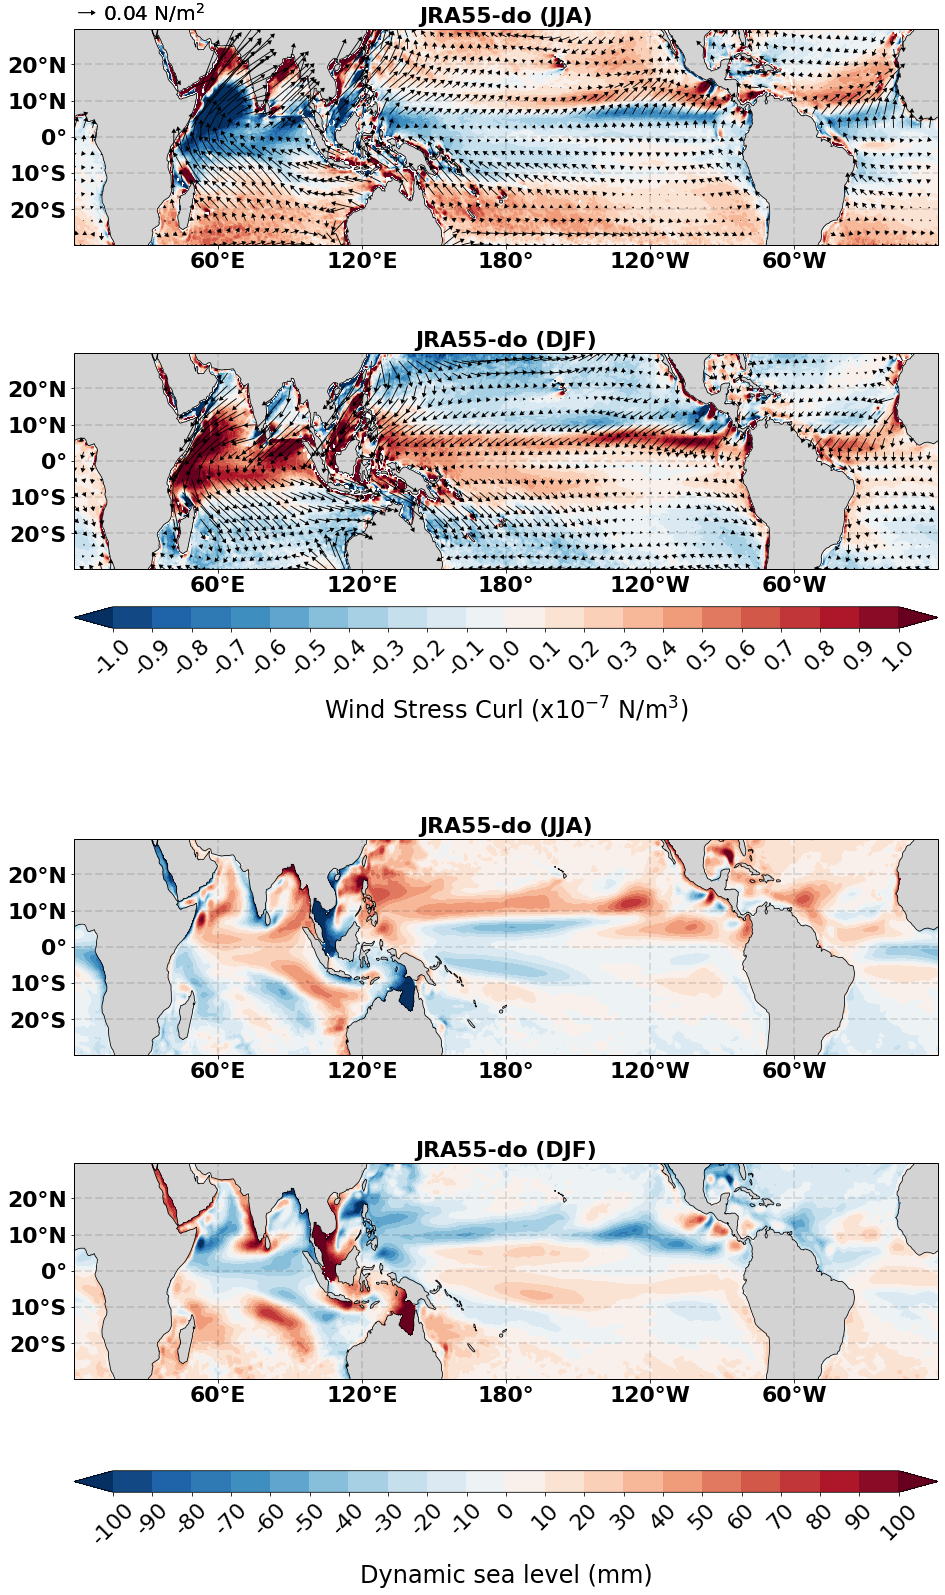

In [19]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(30,15))
devy = 0.3



#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
level = np.linspace(-1e-7, 1e-7, 21)
quarter = [[6,7,8],[12,1,2]]
quarter_name = ['JJA','DJF']
model = 'JRA'
for nseason,season in enumerate(quarter):
    
    ax2=fig.add_axes([0,0-devy*(nseason),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    
    da = (regrid_season_mlist[model]['curl_tauuo']+regrid_season_mlist[model]['curl_tauvo']).sel(month=season).mean(dim='month')
    
    im = (da*da/da).plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
    q=ax2.quiver(season_mlist[model]['tauuo'].lon.values[::15, ::15],
                 season_mlist[model]['tauuo'].lat.values[::15, ::15],
                 season_mlist[model]['tauuo'].sel(month=season).mean('month').values[::15, ::15],
                 season_mlist[model]['tauvo'].sel(month=season).mean('month').values[::15, ::15],
                 scale=2,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
                 transform=ccrs.PlateCarree(central_longitude=0))
    qk = ax2.quiverkey(q, 0.01, 0.215, 0.04, r'0.04 N/m$^2$', labelpos='E',
                   coordinates='figure',fontproperties={'size':20})
    
    if nseason == len(quarter)-1 :
        cbaxes=fig.add_axes([0,0-devy*(nseason)-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.1f"%(n*1e7) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=45) 
        cbar.set_label(label='Wind Stress Curl (x10$^{-7}$ N/m$^3$)',size=24, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('JRA55-do (%s)'%quarter_name[nseason], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')
    
# #########################################################################################
level = np.linspace(-0.1, 0.1, 21)
quarter = [[6,7,8],[12,1,2]]
model = 'JRA'
quarter_name = ['JJA','DJF']
for nseason,season in enumerate(quarter):
    
    ax2=fig.add_axes([0,0-devy*(nseason+3)+0.15,0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    
    da = (season_mlist[model]['zos']).sel(month=season).mean(dim='month')
    
    im = (da*da/da).plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
    if nseason == len(quarter)-1 :
        cbaxes=fig.add_axes([0,0-devy*(nmodel+3)+0.1-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.0f"%(n*1000.) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=45) 
        cbar.set_label(label='Dynamic sea level (mm)',size=24, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('JRA55-do (%s)'%quarter_name[nseason], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')


fig.savefig('../figure/figure12.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


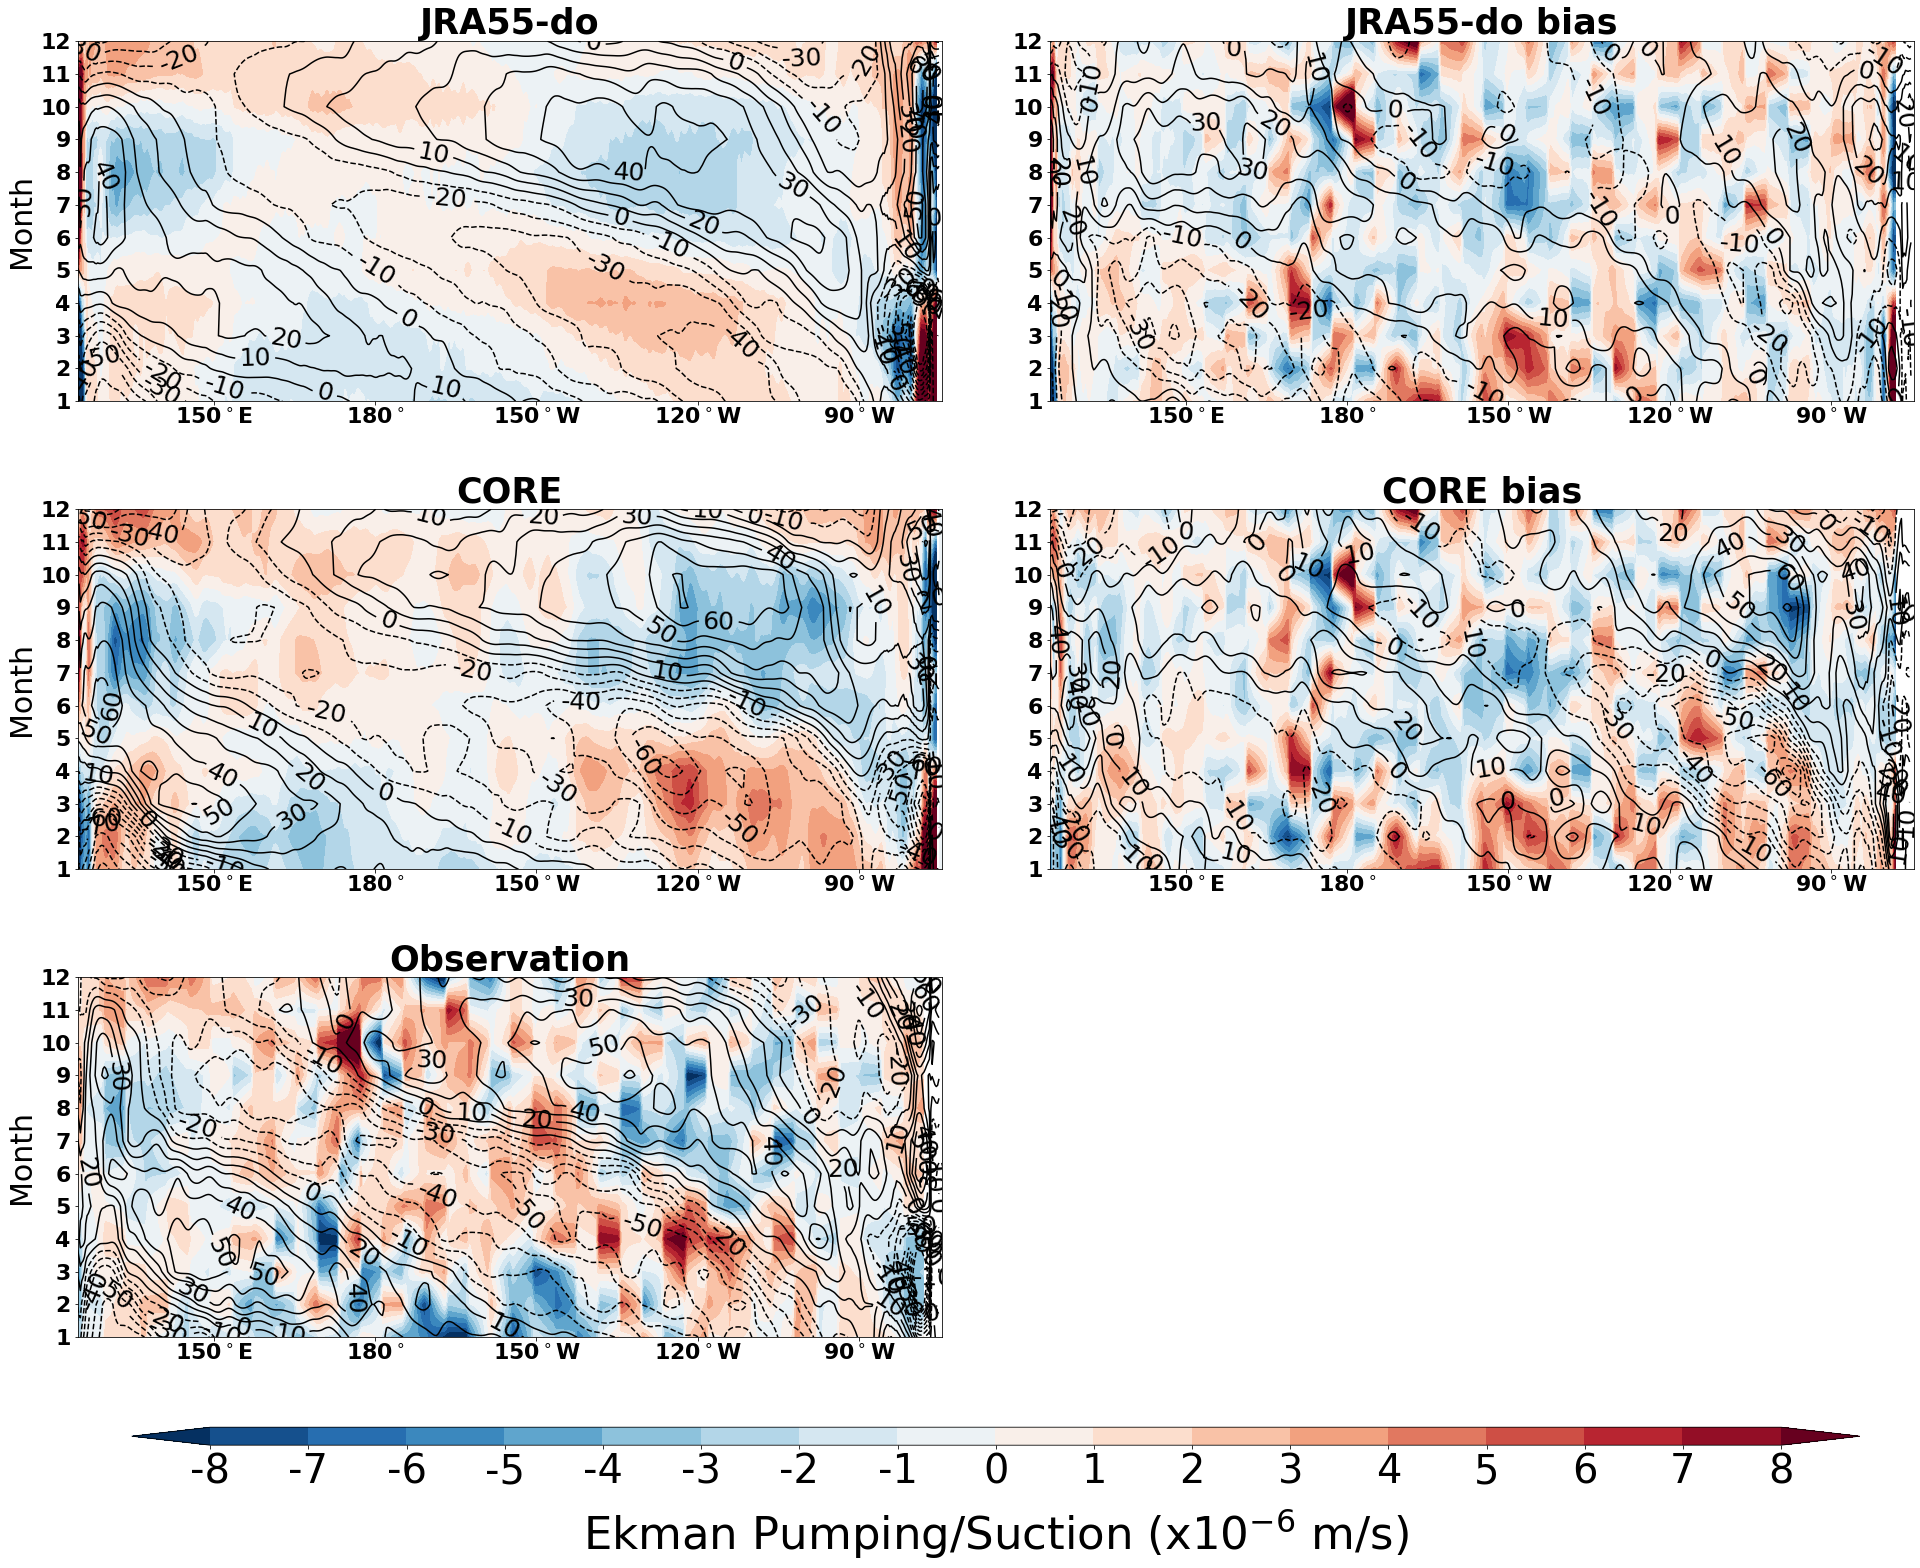

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
devy = 1.3
# setting regional boundary
lon_range = np.array([125,-75])   #-180~180
lat_range = np.array([2,10])

# correct the lon range
lon_range_mod = np.array(lon_range)
lonmin = season_mlist['JRA']['tauuo'].lon.min()
ind1 = np.where(lon_range_mod>np.float(360.+lonmin))[0]
lon_range_mod[ind1] = lon_range_mod[ind1]-360.         # change Lon range to -300-60 (might be different for different


ax2 = fig.add_axes([0,0-(2)*devy,1,1])

var2 = 'Ek_tx'
var3 = 'Ek_ty'

level = np.linspace(-8e-6,8e-6,17)
im = (obs_regrid_season_mlist['WESwind'][var2]\
      +obs_regrid_season_mlist['WESwind'][var3])\
                      .where((obs_regrid_season_mlist['WESwind'][var2].lon<lon_range_mod.max()) &\
                             (obs_regrid_season_mlist['WESwind'][var2].lon>lon_range_mod.min()) &\
                             (obs_regrid_season_mlist['WESwind'][var2].lat<lat_range.max()) &\
                             (obs_regrid_season_mlist['WESwind'][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                      .plot.contourf(x='x',
                                     y='month',
                                     ax=ax2,
                                     levels=level,
                                     cmap='RdBu_r',
                                     extend='both')

cb=im.colorbar
cb.remove()

# cbaxes=fig.add_axes([0.05,-0.2,0.7, 0.025])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.0f"%(n*1e6) for n in level])  
# cbar.ax.tick_params(labelsize=24,rotation=0) 
# cbar.set_label(label='Ekman Pumping/Suction (m/s)',size=24, labelpad=15)

var2 = 'adt'    
clevel = np.linspace(-100,100,21)
cs = (obs_regrid_season_mlist['CMEMS'][var2]*1000.)\
                      .where((obs_regrid_season_mlist["CMEMS"][var2].lon<lon_range_mod.max()) &\
                             (obs_regrid_season_mlist["CMEMS"][var2].lon>lon_range_mod.min()) &\
                             (obs_regrid_season_mlist["CMEMS"][var2].lat<lat_range.max()) &\
                             (obs_regrid_season_mlist["CMEMS"][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                      .plot.contour(x='x',
                                     y='month',
                                     ax=ax2,
                                     levels=clevel,
                                     colors='k')

ax2.clabel(cs, inline=1, fontsize=25,fmt='%1.0f')

# correct the lon range
lon_label = np.array([150,180,-150,-120,-90])
lon_label_mod = lon_label.copy()
ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
lon_label_mod[ind1] = lon_label[ind1]-360.        

ax2.set_xticks(lon_label_mod)
ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                    color='black', weight='bold',size=22)
ax2.set_yticks(np.arange(1,13,1))
ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
ax2.yaxis.tick_left()
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('',size=22)
ax2.set_ylabel('Month',size=30)
ax2.set_title('Observation', color='black', weight='bold',size=35)



for nmodel, model in enumerate(Model_name):
    #### plotting

    ax2 = fig.add_axes([0,0-(nmodel)*devy,1,1])

    var2 = 'Ek_tauuo'
    var3 = 'Ek_tauvo'
    level = np.linspace(-8e-6,8e-6,17)
    im = (regrid_season_mlist[model][var2]+regrid_season_mlist[model][var3])\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')
    var2 = 'zos'    
    clevel = np.linspace(-100,100,21)
    cs = (season_mlist[model][var2]*1000.)\
                          .where((season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (season_mlist[model][var2].lat<lat_range.max()) &\
                                 (season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contour(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=clevel,
                                         colors='k')

    ax2.clabel(cs, inline=1, fontsize=25,fmt='%1.0f')



    cb=im.colorbar
    cb.remove()
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.05,-0.3-(nmodel+1)*devy,1.6, 0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.0f"%(n*1e6) for n in level])  
        cbar.ax.tick_params(labelsize=40,rotation=0) 
        cbar.set_label(label='Ekman Pumping/Suction (x10$^{-6}$ m/s)',size=45, labelpad=15)


    ax3 = fig.add_axes([0.9,0-(nmodel)*devy,1,1])

    var2 = 'Ek_tx'
    var3 = 'Ek_ty'
    var4 = 'Ek_tauuo'
    var5 = 'Ek_tauvo'
#     level = np.linspace(-5e-6,5e-6,21)
    im = (regrid_season_mlist[model][var4]\
          +regrid_season_mlist[model][var5]\
          -obs_regrid_season_mlist['WESwind'][var2]\
          -obs_regrid_season_mlist['WESwind'][var3])\
                          .where((regrid_season_mlist[model][var4].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var4].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var4].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var4].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')

    cb=im.colorbar
    cb.remove()
    
    var2 = 'zos'    
    var3 = 'adt'
    clevel = np.linspace(-100,100,21)
    cs = ((regrid_season_mlist[model][var2]-obs_regrid_season_mlist['CMEMS'][var3])*1000.)\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contour(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=clevel,
                                         colors='k')

    ax3.clabel(cs, inline=1, fontsize=25,fmt='%1.0f')
    
#     if nmodel == len(Model_name)-1:
#         cbaxes=fig.add_axes([0.9,-0.2-nmodel*devy,0.7, 0.03])
#         cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
#         cbar.set_ticks(level)
#         cbar.set_ticklabels(["%0.1e"%(n) for n in level])  
#         cbar.ax.tick_params(labelsize=15,rotation=45) 
#         cbar.set_label(label='Ekman Pumping/Suction (m/s)',size=18, labelpad=15)

    # correct the lon range
    lon_label = np.array([150,180,-150,-120,-90])
    lon_label_mod = lon_label.copy()
    ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
    lon_label_mod[ind1] = lon_label[ind1]-360.        

    ax2.set_xticks(lon_label_mod)
    ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                        color='black', weight='bold',size=22)
    ax2.set_yticks(np.arange(1,13,1))
    ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Month',size=30)
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

    ax3.set_xticks(lon_label_mod)
    ax3.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                        color='black', weight='bold',size=22)
    ax3.set_yticks(np.arange(1,13,1))
    ax3.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax3.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

fig.savefig('../figure/figure13.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


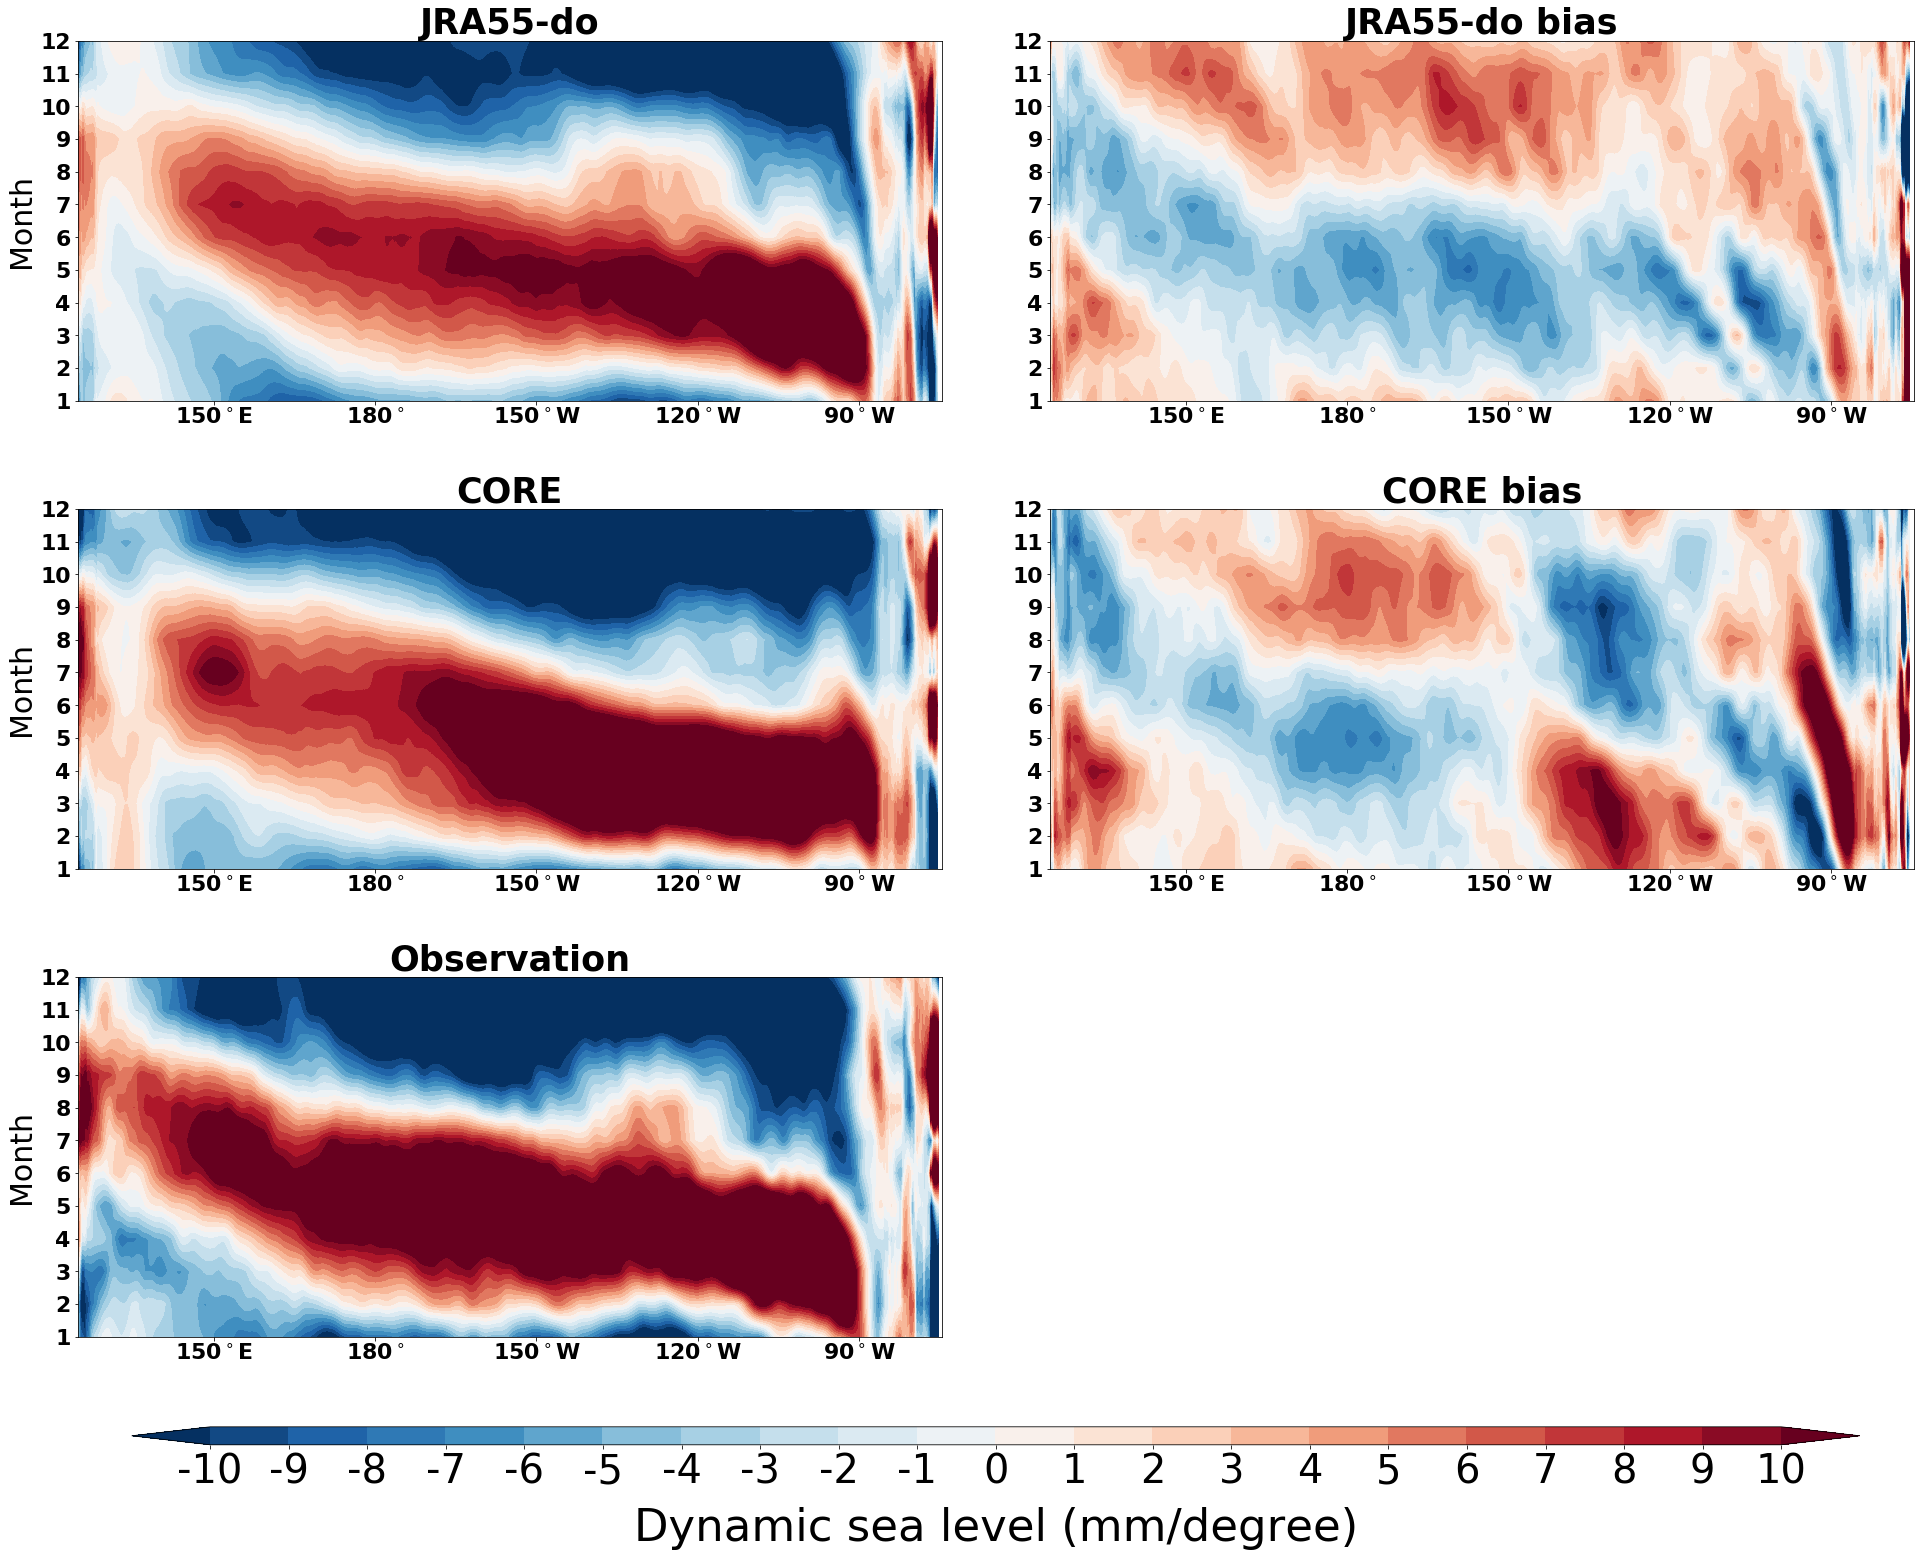

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
devy = 1.3
# setting regional boundary
lon_range = np.array([125,-75])   #-180~180
lat_range = np.array([2,10])

# correct the lon range
lon_range_mod = np.array(lon_range)
lonmin = season_mlist['JRA']['tauuo'].lon.min()
ind1 = np.where(lon_range_mod>np.float(360.+lonmin))[0]
lon_range_mod[ind1] = lon_range_mod[ind1]-360.         # change Lon range to -300-60 (might be different for different


ax2 = fig.add_axes([0,0-(2)*devy,1,1])


var2 = 'adt'    
clevel = np.linspace(-10,10,21)
im = (obs_regrid_season_mlist['CMEMS'][var2]*1000.)\
                      .where((obs_regrid_season_mlist["CMEMS"][var2].lon<lon_range_mod.max()) &\
                             (obs_regrid_season_mlist["CMEMS"][var2].lon>lon_range_mod.min()) &\
                             (obs_regrid_season_mlist["CMEMS"][var2].lat<lat_range.max()) &\
                             (obs_regrid_season_mlist["CMEMS"][var2].lat>lat_range.min()),drop=True)\
                      .differentiate('y').mean(dim='y')\
                      .plot.contourf(x='x',
                                     y='month',
                                     ax=ax2,
                                     levels=clevel,
                                     cmap='RdBu_r',
                                     extend='both')
cb=im.colorbar
cb.remove()

# correct the lon range
lon_label = np.array([150,180,-150,-120,-90])
lon_label_mod = lon_label.copy()
ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
lon_label_mod[ind1] = lon_label[ind1]-360.        

ax2.set_xticks(lon_label_mod)
ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                    color='black', weight='bold',size=22)
ax2.set_yticks(np.arange(1,13,1))
ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
ax2.yaxis.tick_left()
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('',size=22)
ax2.set_ylabel('Month',size=30)
ax2.set_title('Observation', color='black', weight='bold',size=35)



for nmodel, model in enumerate(Model_name):
    #### plotting

    ax2 = fig.add_axes([0,0-(nmodel)*devy,1,1])

    var2 = 'zos'    
    im = (season_mlist[model][var2]*1000.)\
                          .where((season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (season_mlist[model][var2].lat<lat_range.max()) &\
                                 (season_mlist[model][var2].lat>lat_range.min()),drop=True)\
                          .differentiate('y').mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=clevel,
                                         cmap='RdBu_r',
                                         extend='both')




    cb=im.colorbar
    cb.remove()
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.05,-0.3-(nmodel+1)*devy,1.6, 0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
        cbar.set_ticks(clevel)
        cbar.set_ticklabels(["%0.0f"%(n) for n in clevel])  
        cbar.ax.tick_params(labelsize=40,rotation=0) 
        cbar.set_label(label='Dynamic sea level (mm/degree)',size=45, labelpad=15)


    ax3 = fig.add_axes([0.9,0-(nmodel)*devy,1,1])



    
    var2 = 'zos'    
    var3 = 'adt'
    im = ((regrid_season_mlist[model][var2].differentiate('y')\
           -obs_regrid_season_mlist['CMEMS'][var3].differentiate('y'))*1000.)\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=clevel,
                                         cmap='RdBu_r',
                                         extend='both')
    cb=im.colorbar
    cb.remove()
    
#     if nmodel == len(Model_name)-1:
#         cbaxes=fig.add_axes([0.9,-0.2-nmodel*devy,0.7, 0.03])
#         cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
#         cbar.set_ticks(level)
#         cbar.set_ticklabels(["%0.1e"%(n) for n in level])  
#         cbar.ax.tick_params(labelsize=15,rotation=45) 
#         cbar.set_label(label='Ekman Pumping/Suction (m/s)',size=18, labelpad=15)

    # correct the lon range
    lon_label = np.array([150,180,-150,-120,-90])
    lon_label_mod = lon_label.copy()
    ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
    lon_label_mod[ind1] = lon_label[ind1]-360.        

    ax2.set_xticks(lon_label_mod)
    ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                        color='black', weight='bold',size=22)
    ax2.set_yticks(np.arange(1,13,1))
    ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Month',size=30)
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

    ax3.set_xticks(lon_label_mod)
    ax3.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                        color='black', weight='bold',size=22)
    ax3.set_yticks(np.arange(1,13,1))
    ax3.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax3.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

# fig.savefig('../figure/figure13_reply1.pdf', dpi=300, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#                 transparent=False, bbox_inches="tight", pad_inches=None,
#                 frameon=None)


Text(0.5, 1.0, 'CORE minus JRA55-do')

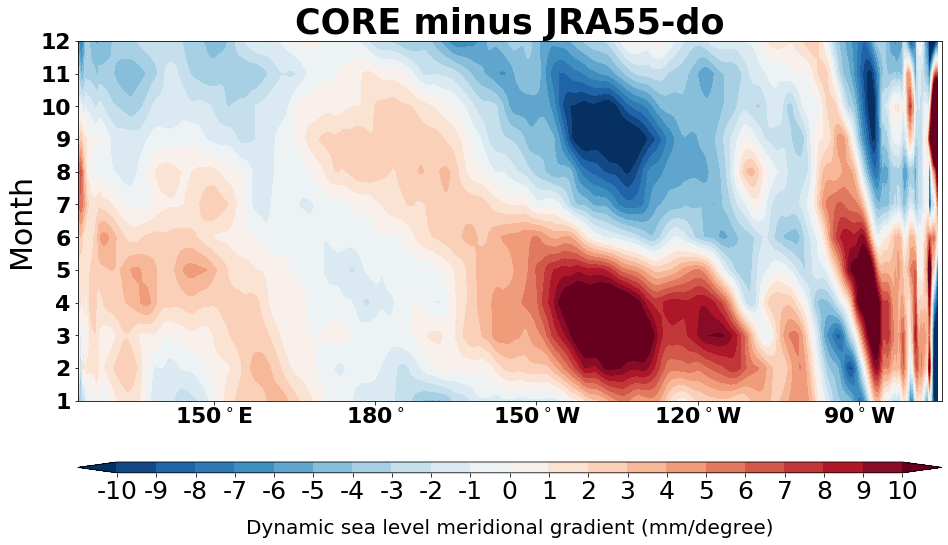

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
# setting regional boundary
lon_range = np.array([125,-75])   #-180~180
lat_range = np.array([2,10])

# correct the lon range
lon_range_mod = np.array(lon_range)
lonmin = season_mlist['JRA']['tauuo'].lon.min()
ind1 = np.where(lon_range_mod>np.float(360.+lonmin))[0]
lon_range_mod[ind1] = lon_range_mod[ind1]-360.         # change Lon range to -300-60 (might be different for different


ax2 = fig.add_axes([0,0,1,1])


im = ((regrid_season_mlist['CORE'][var2].differentiate('y')\
       -regrid_season_mlist['JRA'][var2].differentiate('y'))*1000.)\
                      .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                             (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                             (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                             (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                      .plot.contourf(x='x',
                                     y='month',
                                     ax=ax2,
                                     levels=clevel,
                                     cmap='RdBu_r',
                                     extend='both')
cb=im.colorbar
cb.remove()

cbaxes=fig.add_axes([0,-0.2,0.8, 0.03])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
cbar.set_ticks(clevel)
cbar.set_ticklabels(["%0.0f"%(n) for n in clevel])  
cbar.ax.tick_params(labelsize=25,rotation=0)
cbar.set_label(label='Dynamic sea level meridional gradient (mm/degree)',size=20, labelpad=15)

# correct the lon range
lon_label = np.array([150,180,-150,-120,-90])
lon_label_mod = lon_label.copy()
ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
lon_label_mod[ind1] = lon_label[ind1]-360.        

ax2.set_xticks(lon_label_mod)
ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'], 
                    color='black', weight='bold',size=22)
ax2.set_yticks(np.arange(1,13,1))
ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
ax2.yaxis.tick_left()
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('',size=22)
ax2.set_ylabel('Month',size=30)
ax2.set_title('CORE minus JRA55-do', color='black', weight='bold',size=35)


fig.savefig('../figure/figure_reply1_dslgradient.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


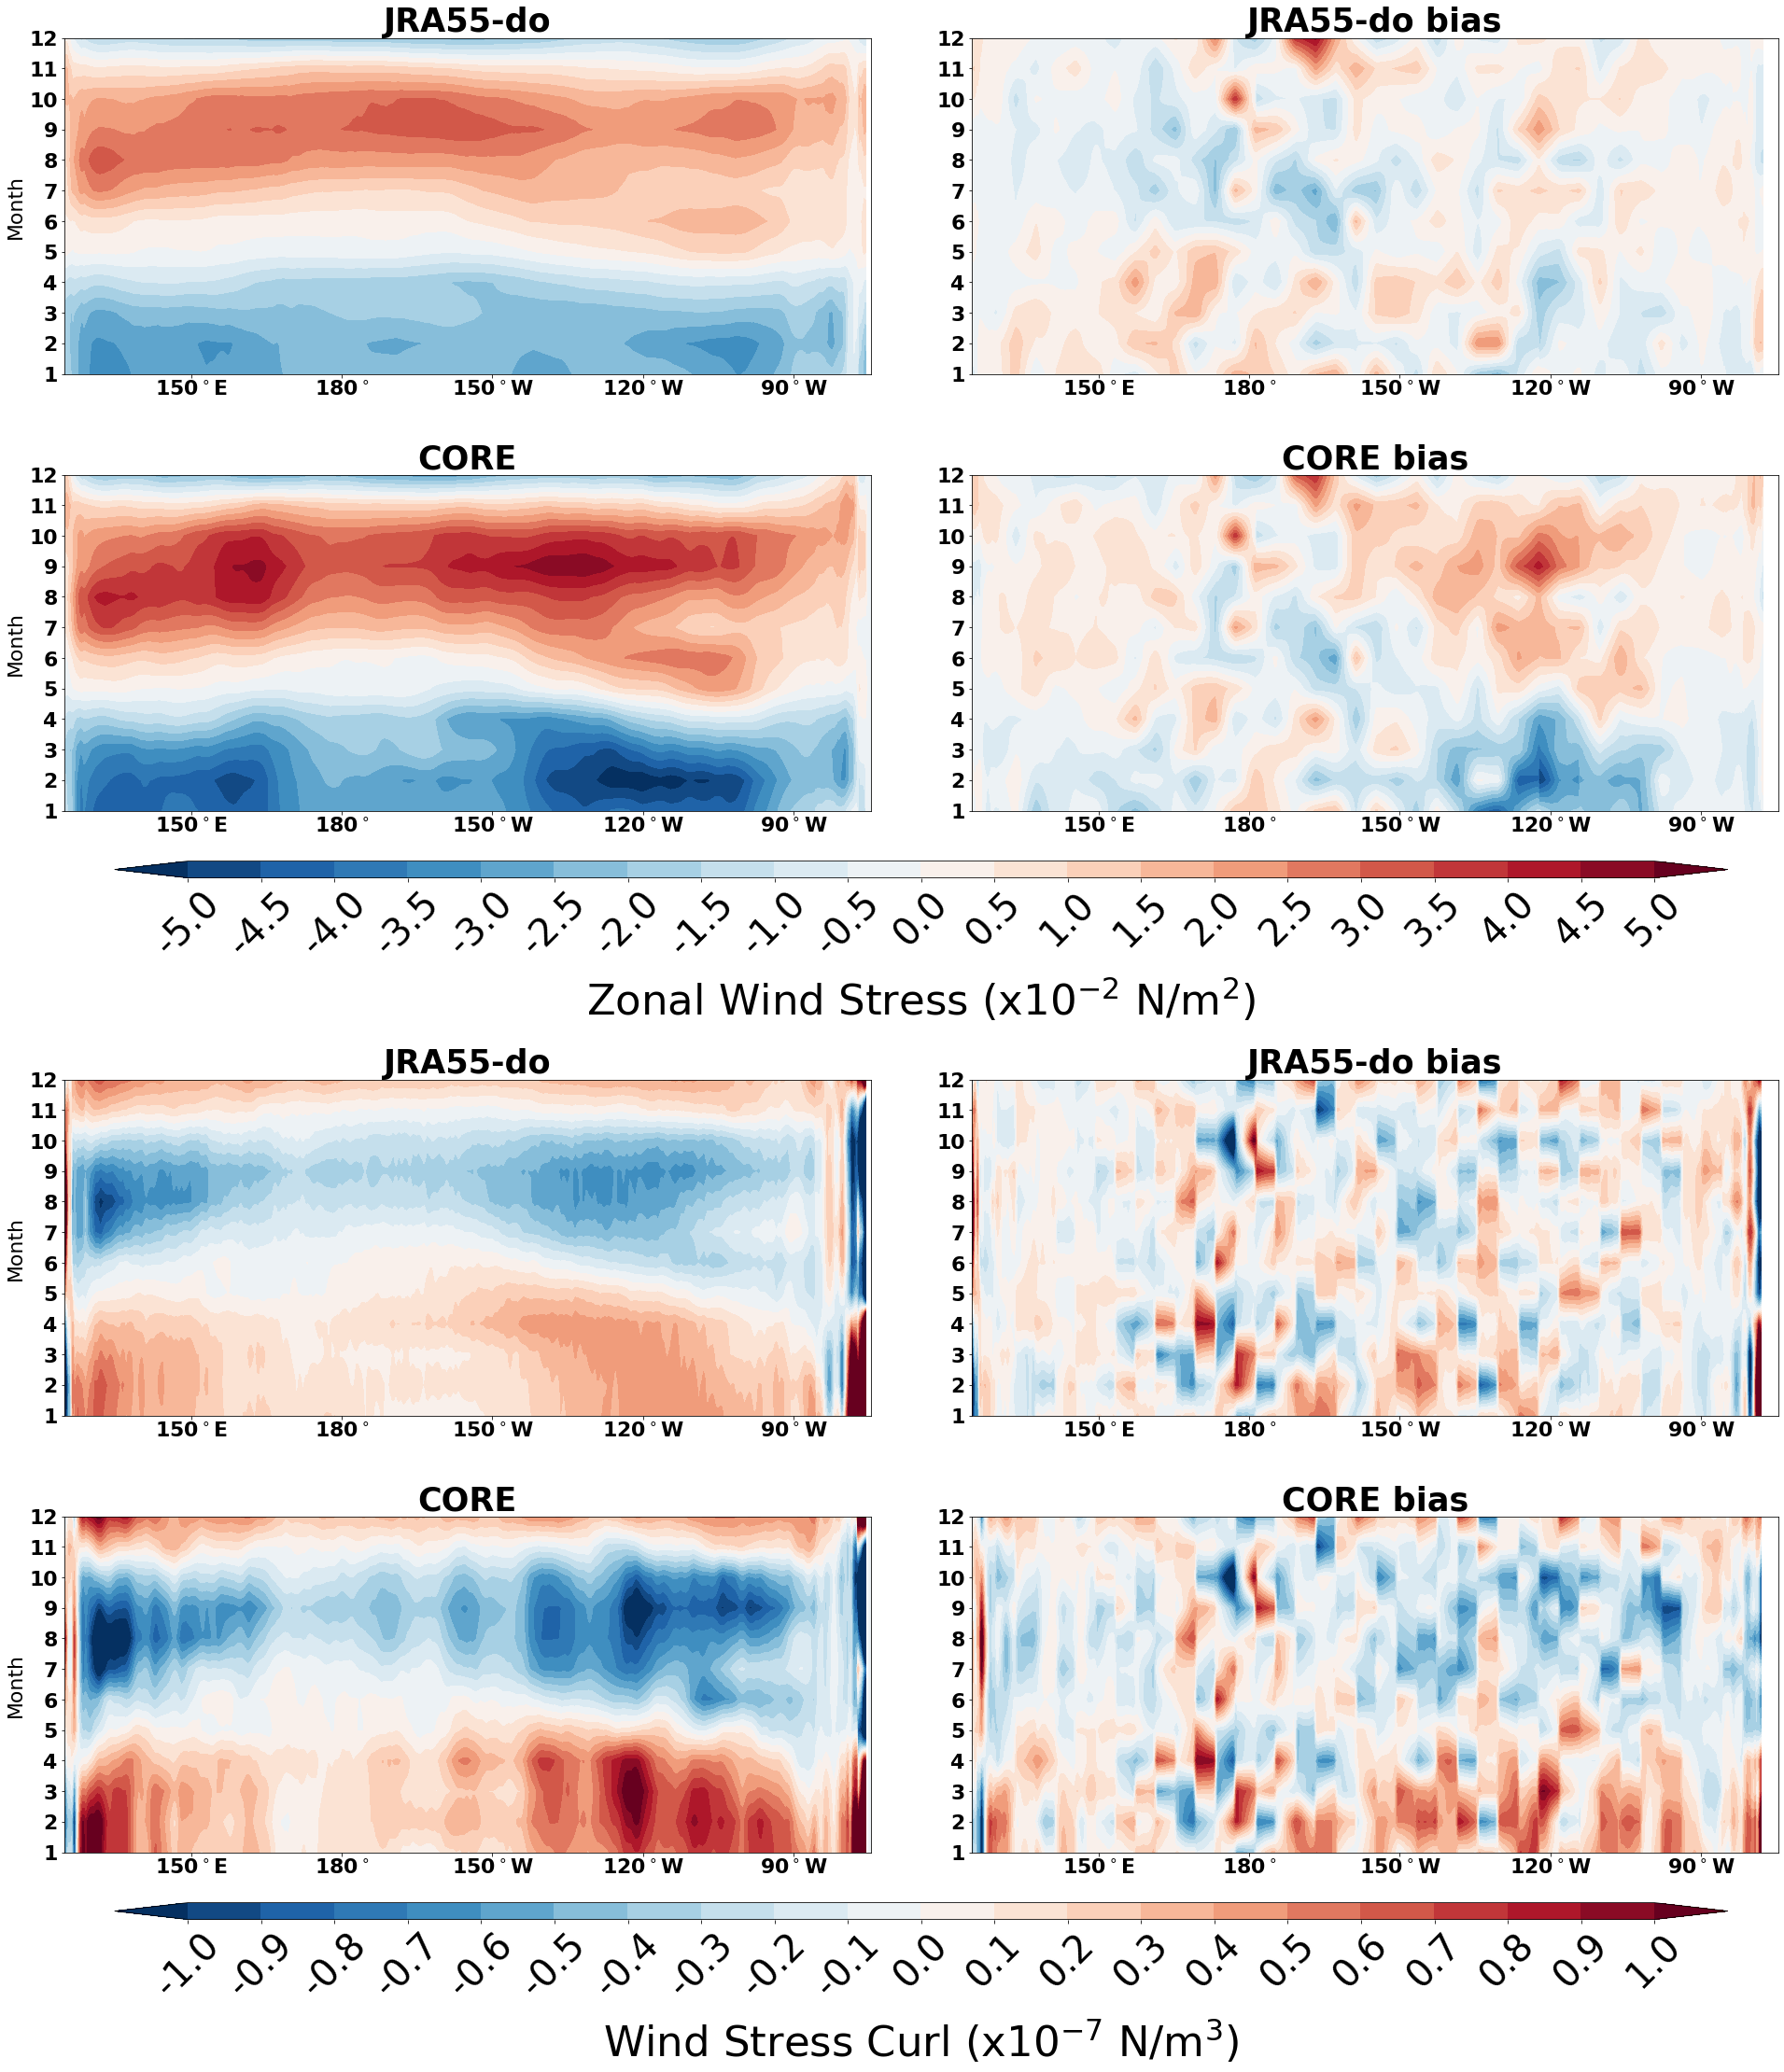

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
devy = 1.3
# setting regional boundary
lon_range = np.array([125,-75])   #-180~180
lat_range = np.array([2,10])

# correct the lon range
lon_range_mod = np.array(lon_range)
lonmin = season_mlist['JRA']['tauuo'].lon.min()
ind1 = np.where(lon_range_mod>np.float(360.+lonmin))[0]
lon_range_mod[ind1] = lon_range_mod[ind1]-360.         # change Lon range to -300-60 (might be different for different

for nmodel, model in enumerate(Model_name):
    #### plotting

    ax2 = fig.add_axes([0,0-nmodel*devy,1,1])

    var2 = 'tauuo'
    level = np.linspace(-5e-2,5e-2,21)
    im = (regrid_season_mlist[model][var2])\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')


    cb=im.colorbar
    cb.remove()
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.05,-0.2-nmodel*devy,1.6, 0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.1f"%(n*1e2) for n in level])  
        cbar.ax.tick_params(labelsize=40,rotation=45) 
        cbar.set_label(label='Zonal Wind Stress (x10$^{-2}$ N/m$^2$)',size=45, labelpad=15)


    ax3 = fig.add_axes([0.9,0-nmodel*devy,1,1])
    var2 = 'tx'
    var4 = 'tauuo'
    im = (regrid_season_mlist[model][var4]-obs_regrid_season_mlist['WESwind'][var2])\
                          .where((regrid_season_mlist[model][var4].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var4].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var4].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var4].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')

    cb=im.colorbar
    cb.remove()

    # correct the lon range
    lon_label = np.array([150,180,-150,-120,-90])
    lon_label_mod = lon_label.copy()
    ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
    lon_label_mod[ind1] = lon_label[ind1]-360.        

    ax2.set_xticks(lon_label_mod)
    ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax2.set_yticks(np.arange(1,13,1))
    ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Month',size=22)
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

    ax3.set_xticks(lon_label_mod)
    ax3.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax3.set_yticks(np.arange(1,13,1))
    ax3.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax3.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

###########################################################################

for nmodel, model in enumerate(Model_name):
    #### plotting

    ax2 = fig.add_axes([0,0-(nmodel+2)*devy-0.5,1,1])

    var2 = 'curl_tauuo'
    var3 = 'curl_tauvo'
    level = np.linspace(-1e-7,1e-7,21)
    im = (regrid_season_mlist[model][var2]+regrid_season_mlist[model][var3])\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')


    cb=im.colorbar
    cb.remove()
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.05,-0.2-(nmodel+2)*devy-0.5,1.6, 0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.1f"%(n*1e7) for n in level])  
        cbar.ax.tick_params(labelsize=40,rotation=45) 
        cbar.set_label(label='Wind Stress Curl (x10$^{-7}$ N/m$^3$)',size=45, labelpad=15)


    ax3 = fig.add_axes([0.9,0-(nmodel+2)*devy-0.5,1,1])

    var2 = 'curl_tx'
    var3 = 'curl_ty'
    var4 = 'curl_tauuo'
    var5 = 'curl_tauvo'
    im = (regrid_season_mlist[model][var4]\
          +regrid_season_mlist[model][var5]\
          -obs_regrid_season_mlist['WESwind'][var2]\
          -obs_regrid_season_mlist['WESwind'][var3])\
                          .where((regrid_season_mlist[model][var4].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var4].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var4].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var4].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')

    cb=im.colorbar
    cb.remove()

    # correct the lon range
    lon_label = np.array([150,180,-150,-120,-90])
    lon_label_mod = lon_label.copy()
    ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
    lon_label_mod[ind1] = lon_label[ind1]-360.        

    ax2.set_xticks(lon_label_mod)
    ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax2.set_yticks(np.arange(1,13,1))
    ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Month',size=22)
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

    ax3.set_xticks(lon_label_mod)
    ax3.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax3.set_yticks(np.arange(1,13,1))
    ax3.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax3.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=35)


fig.savefig('../figure/figure14.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


In [23]:
var2

'curl_tx'

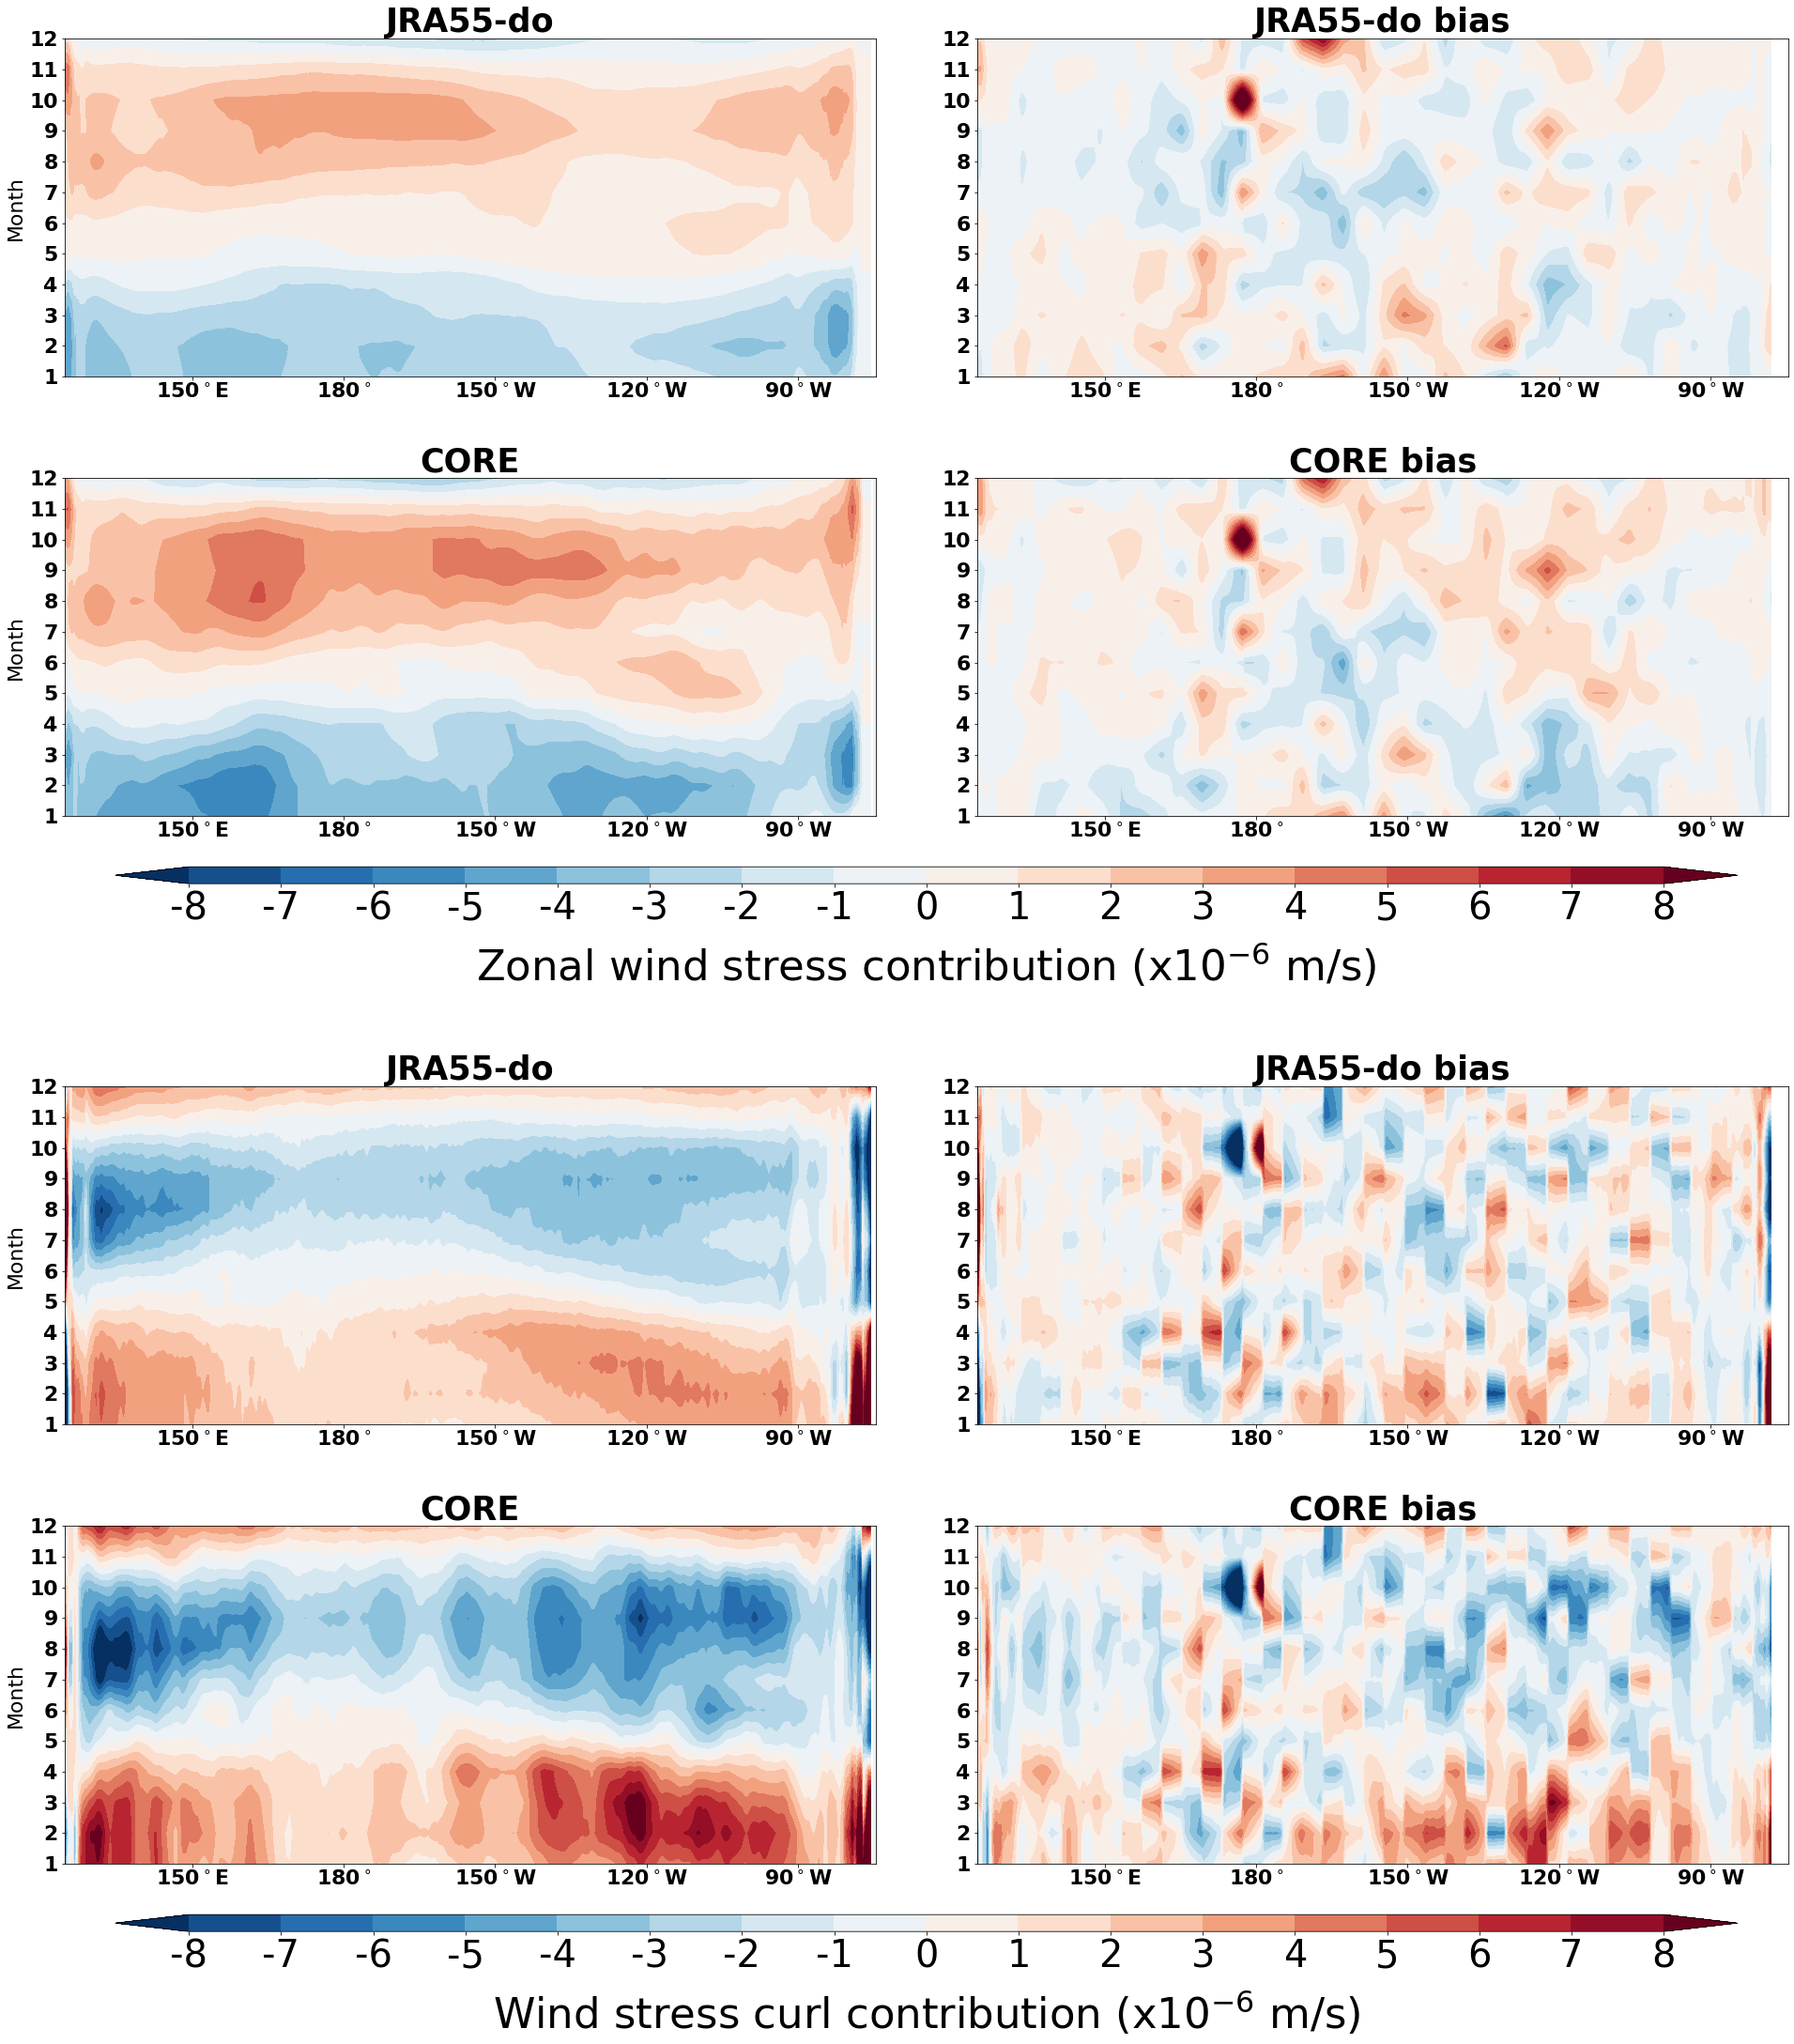

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
devy = 1.3
# setting regional boundary
lon_range = np.array([125,-75])   #-180~180
lat_range = np.array([2,10])

# correct the lon range
lon_range_mod = np.array(lon_range)
lonmin = season_mlist['JRA']['tauuo'].lon.min()
ind1 = np.where(lon_range_mod>np.float(360.+lonmin))[0]
lon_range_mod[ind1] = lon_range_mod[ind1]-360.         # change Lon range to -300-60 (might be different for different

for nmodel, model in enumerate(Model_name):
    #### plotting

    ax2 = fig.add_axes([0,0-nmodel*devy,1,1])

    var2 = 'Ek_zonal'
    level = np.linspace(-8e-6,8e-6,17)
    im = (regrid_season_mlist[model][var2])\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')


    cb=im.colorbar
    cb.remove()
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.05,-0.2-nmodel*devy,1.6, 0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.0f"%(n*1e6) for n in level])  
        cbar.ax.tick_params(labelsize=40,rotation=0) 
        cbar.set_label(label='Zonal wind stress contribution (x10$^{-6}$ m/s)',size=45, labelpad=15)


    ax3 = fig.add_axes([0.9,0-nmodel*devy,1,1])
    var2 = 'Ek_zonal'
    var4 = 'Ek_zonal'
    im = (regrid_season_mlist[model][var4]-obs_regrid_season_mlist['WESwind'][var2])\
                          .where((regrid_season_mlist[model][var4].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var4].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var4].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var4].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')

    cb=im.colorbar
    cb.remove()

    # correct the lon range
    lon_label = np.array([150,180,-150,-120,-90])
    lon_label_mod = lon_label.copy()
    ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
    lon_label_mod[ind1] = lon_label[ind1]-360.        

    ax2.set_xticks(lon_label_mod)
    ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax2.set_yticks(np.arange(1,13,1))
    ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Month',size=22)
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

    ax3.set_xticks(lon_label_mod)
    ax3.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax3.set_yticks(np.arange(1,13,1))
    ax3.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax3.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

###########################################################################

for nmodel, model in enumerate(Model_name):
    #### plotting

    ax2 = fig.add_axes([0,0-(nmodel+2)*devy-0.5,1,1])

    var2 = 'Ek_curl'
    im = (regrid_season_mlist[model][var2])\
                          .where((regrid_season_mlist[model][var2].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var2].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var2].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var2].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax2,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')


    cb=im.colorbar
    cb.remove()
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.05,-0.2-(nmodel+2)*devy-0.5,1.6, 0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal',extend='both')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.0f"%(n*1e6) for n in level])  
        cbar.ax.tick_params(labelsize=40,rotation=0) 
        cbar.set_label(label='Wind stress curl contribution (x10$^{-6}$ m/s)',size=45, labelpad=15)


    ax3 = fig.add_axes([0.9,0-(nmodel+2)*devy-0.5,1,1])

    var2 = 'Ek_curl'
    var4 = 'Ek_curl'
    im = (regrid_season_mlist[model][var4]\
          -obs_regrid_season_mlist['WESwind'][var2])\
                          .where((regrid_season_mlist[model][var4].lon<lon_range_mod.max()) &\
                                 (regrid_season_mlist[model][var4].lon>lon_range_mod.min()) &\
                                 (regrid_season_mlist[model][var4].lat<lat_range.max()) &\
                                 (regrid_season_mlist[model][var4].lat>lat_range.min()),drop=True).mean(dim='y')\
                          .plot.contourf(x='x',
                                         y='month',
                                         ax=ax3,
                                         levels=level,
                                         cmap='RdBu_r',
                                         extend='both')

    cb=im.colorbar
    cb.remove()

    # correct the lon range
    lon_label = np.array([150,180,-150,-120,-90])
    lon_label_mod = lon_label.copy()
    ind1 = np.where(lon_label>np.float(360.+lonmin))[0]
    lon_label_mod[ind1] = lon_label[ind1]-360.        

    ax2.set_xticks(lon_label_mod)
    ax2.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax2.set_yticks(np.arange(1,13,1))
    ax2.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('',size=22)
    ax2.set_ylabel('Month',size=22)
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)

    ax3.set_xticks(lon_label_mod)
    ax3.set_xticklabels(['150$^\circ$E','180$^\circ$','150$^\circ$W','120$^\circ$W','90$^\circ$W'],
                        color='black', weight='bold',size=22)
    ax3.set_yticks(np.arange(1,13,1))
    ax3.set_yticklabels(np.arange(1,13,1), color='black', weight='bold',size=22)
    ax3.yaxis.tick_left()
    # ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax3.set_xlabel('',size=22)
    ax3.set_ylabel('',size=22)
    ax3.set_title('%s bias'%Model_legend_name[nmodel], color='black', weight='bold',size=35)


fig.savefig('../figure/figure14_test.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)
